In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from matplotlib.lines import Line2D

from matplotlib.colors import ListedColormap
colors5 = ["#005845", "#84C497", "#F28E77", "#64C1CB", "#F3A44C"]
syke5 = ListedColormap(colors5)

colors9 = ["#005845", "#84C497", "#F28E77", "#64C1CB", "#F3A44C", "#B34733", "#006085", "#575756", "#BB5B0F"]

syke9 = ListedColormap(colors9)


custom_lines = [Line2D([0], [0], color=syke5(0.0), lw=4),
                Line2D([0], [0], color=syke5(.25), lw=4),
                Line2D([0], [0], color=syke5(.50), lw=4),
                Line2D([0], [0], color=syke5(.75), lw=4),
                Line2D([0], [0], color=syke5(1.0), lw=4),]

model_path = Path('../runs')

# Cross-validation

Evaluate the cross-validation performance of different YOLOv8 models.

Metrics used here are the following:

* $Precision = \frac{tp}{tp+fp}$, with IoU-threshold of 0.5
* $Recall = \frac{tp}{tp+fn}$, with IoU-threshold of 0.5
* $mAP50$ is the area under the precision-recall curve with IoU threshold of 0.5
* $mAP$ or $AP@[.5:.95]$ is the average $mAP$ for IoU from 0.5 to 0.95 with a step size of 0.05
* $IoU$ corresponds to Intersection-over-Union, the ratio between the overlap and union of two bounding boxes

All models were trained for maximum 200 epochs, with `patience=30` monitoring mAP.

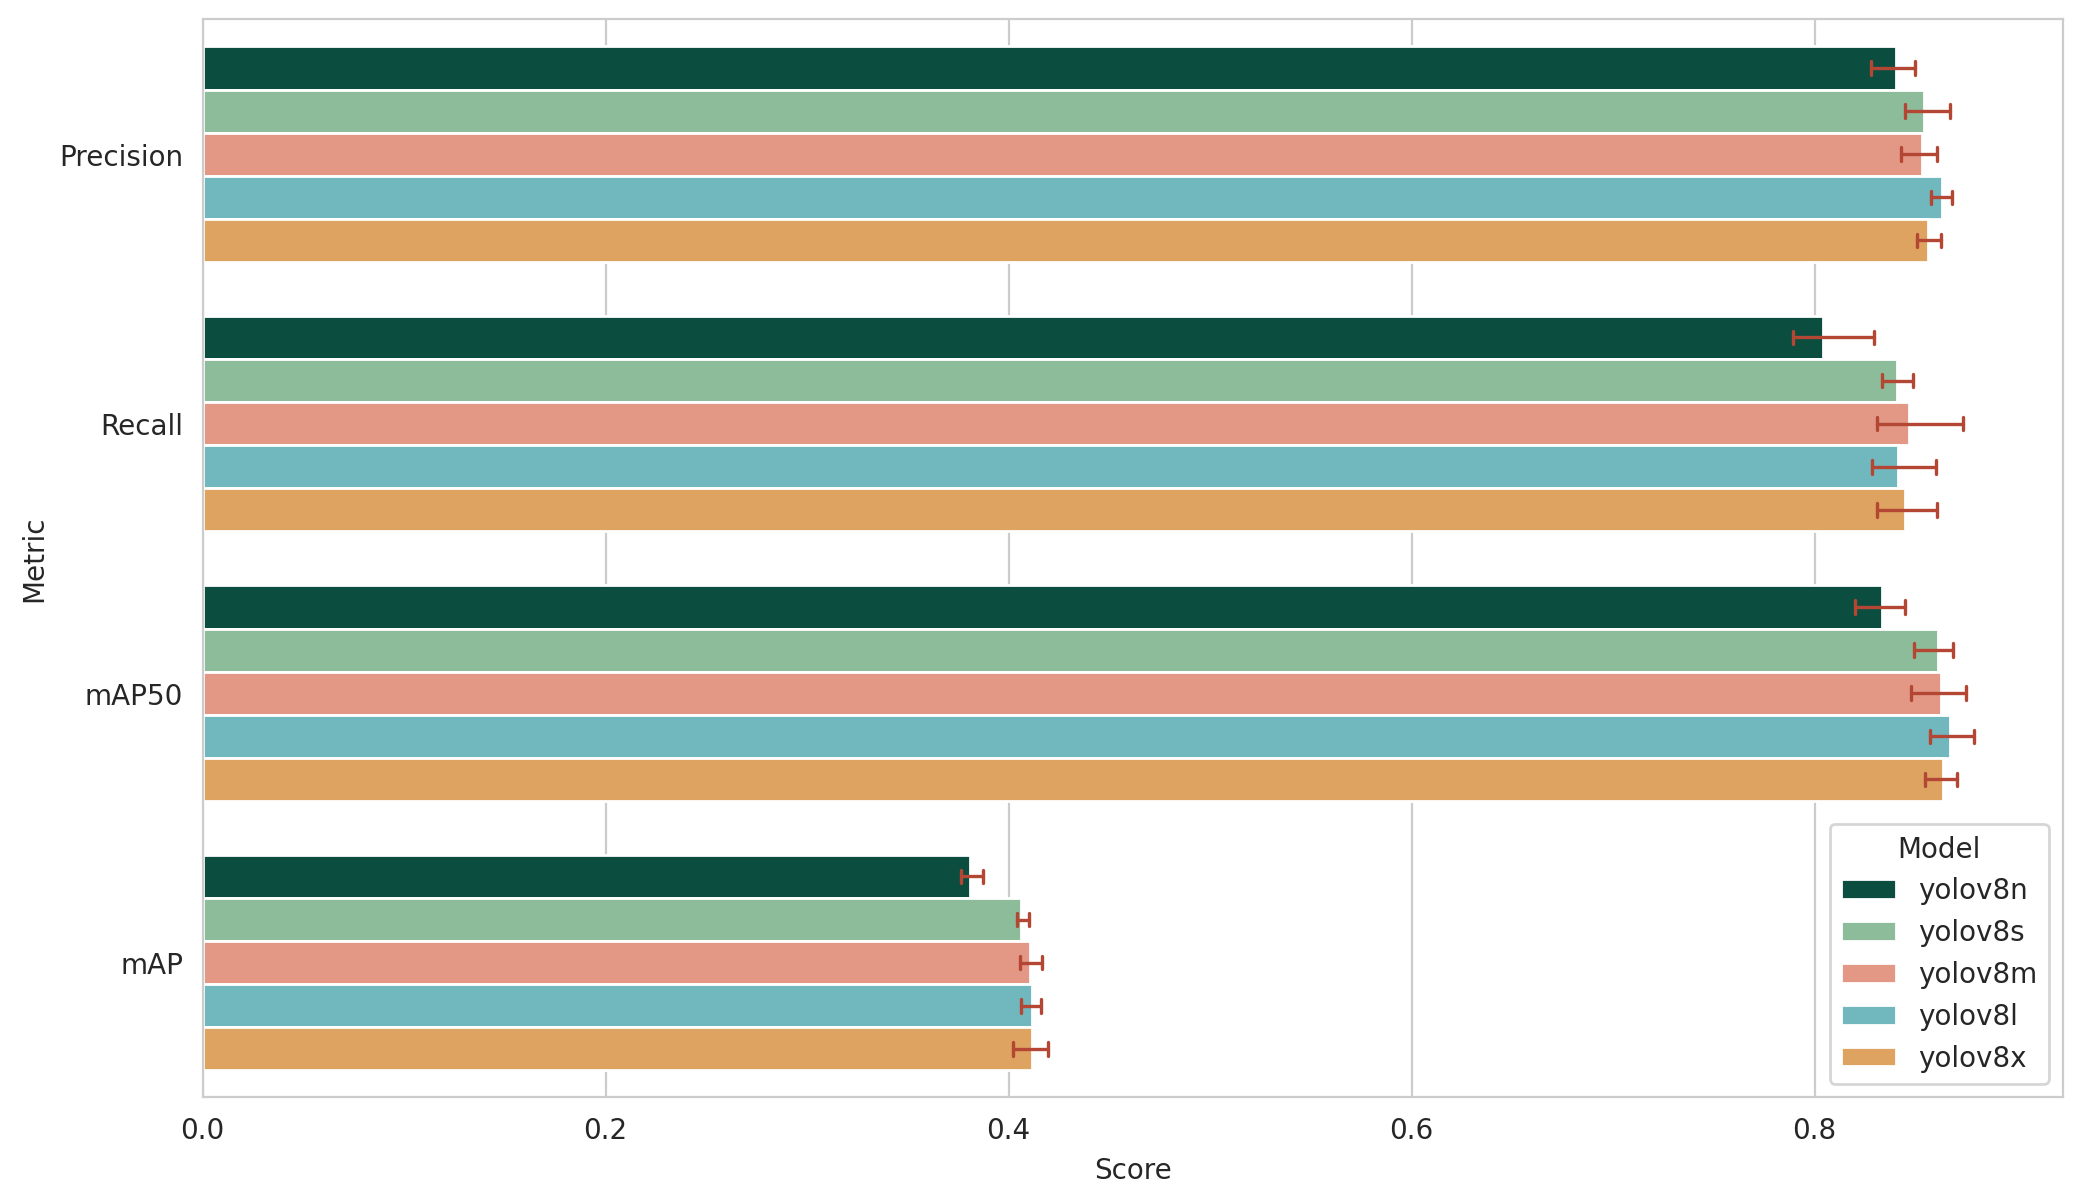

In [ ]:
#| echo: False
#| label: fig-cvres
#| fig-cap: 5-fold crossvalidation results for different model architectures.

custom_lines = [Line2D([0], [0], color=syke5(0.0), lw=4),
                Line2D([0], [0], color=syke5(.25), lw=4),
                Line2D([0], [0], color=syke5(.50), lw=4),
                Line2D([0], [0], color=syke5(.75), lw=4),
                Line2D([0], [0], color=syke5(1.0), lw=4),]

pres = []
recs = []
mAP50s = []
mAPs = []

models = ['yolov8n_Adam', 'yolov8s_Adam', 'yolov8m_Adam',
          'yolov8l_Adam', 'yolov8x_Adam']
folds = os.listdir(model_path/models[1])

results = []
for m in models:
    for f in folds:
        res = pd.read_csv(model_path/m/f/'results.csv')
        res.rename(columns=lambda x: x.strip(), inplace=True)
        pre = np.array(res['metrics/precision(B)']).max()
        rec = np.array(res['metrics/recall(B)']).max()
        mAP50 = np.array(res['metrics/mAP50(B)']).max()
        mAP = np.array(res['metrics/mAP50-95(B)']).max()
        
        results.append([m.split('_')[0],f,pre, rec, mAP50, mAP])
resdf = pd.DataFrame(columns=['Model', 'fold', 'Precision', 'Recall', 'mAP50', 'mAP'], data=results)
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1, figsize=(12,7), dpi=200)
ax.set_ylim([0,1])
sns.barplot(y='variable', x='value', hue='Model', data=pd.melt(resdf, id_vars=['Model', 'fold']),
            palette=colors5, errorbar=('ci', 100), capsize=.05, errcolor='#b34733', errwidth=1.2)
sns.move_legend(ax, 'lower right')
plt.ylabel('Metric')
plt.xlabel('Score')

plt.show()

In [ ]:
resdf.pivot_table(values=['Precision', 'Recall', 'mAP50', 'mAP'], index=['Model'], 
                  aggfunc={'Precision':[min, max, np.mean],
                           'Recall':[min, max, np.mean],
                           'mAP50':[min, max, np.mean],
                           'mAP':[min, max, np.mean]})

Precision                      Recall                         mAP  \
              max      mean      min      max      mean      min      max   
Model                                                                       
yolov8l   0.86911  0.863254  0.85604  0.86468  0.841572  0.82725  0.41694   
yolov8m   0.86108  0.853192  0.84191  0.87385  0.846722  0.83000  0.41739   
yolov8n   0.85001  0.840136  0.82782  0.82951  0.804012  0.78738  0.38816   
yolov8s   0.86717  0.854216  0.84347  0.84939  0.840650  0.83222  0.41098   
yolov8x   0.86411  0.856008  0.85045  0.86086  0.845044  0.83029  0.42065   

                              mAP50                     
             mean      min      max      mean      min  
Model                                                   
yolov8l  0.411712  0.40505  0.88288  0.867134  0.85743  
yolov8m  0.410742  0.40496  0.87772  0.862594  0.84602  
yolov8n  0.380828  0.37637  0.84525  0.833424  0.81883  
yolov8s  0.406258  0.40374  0.86933  0.861404  0.84934  
yolov8x  0.411532  0.40231  0.87069  0.863538  0.85316

## Visual comparisation of results

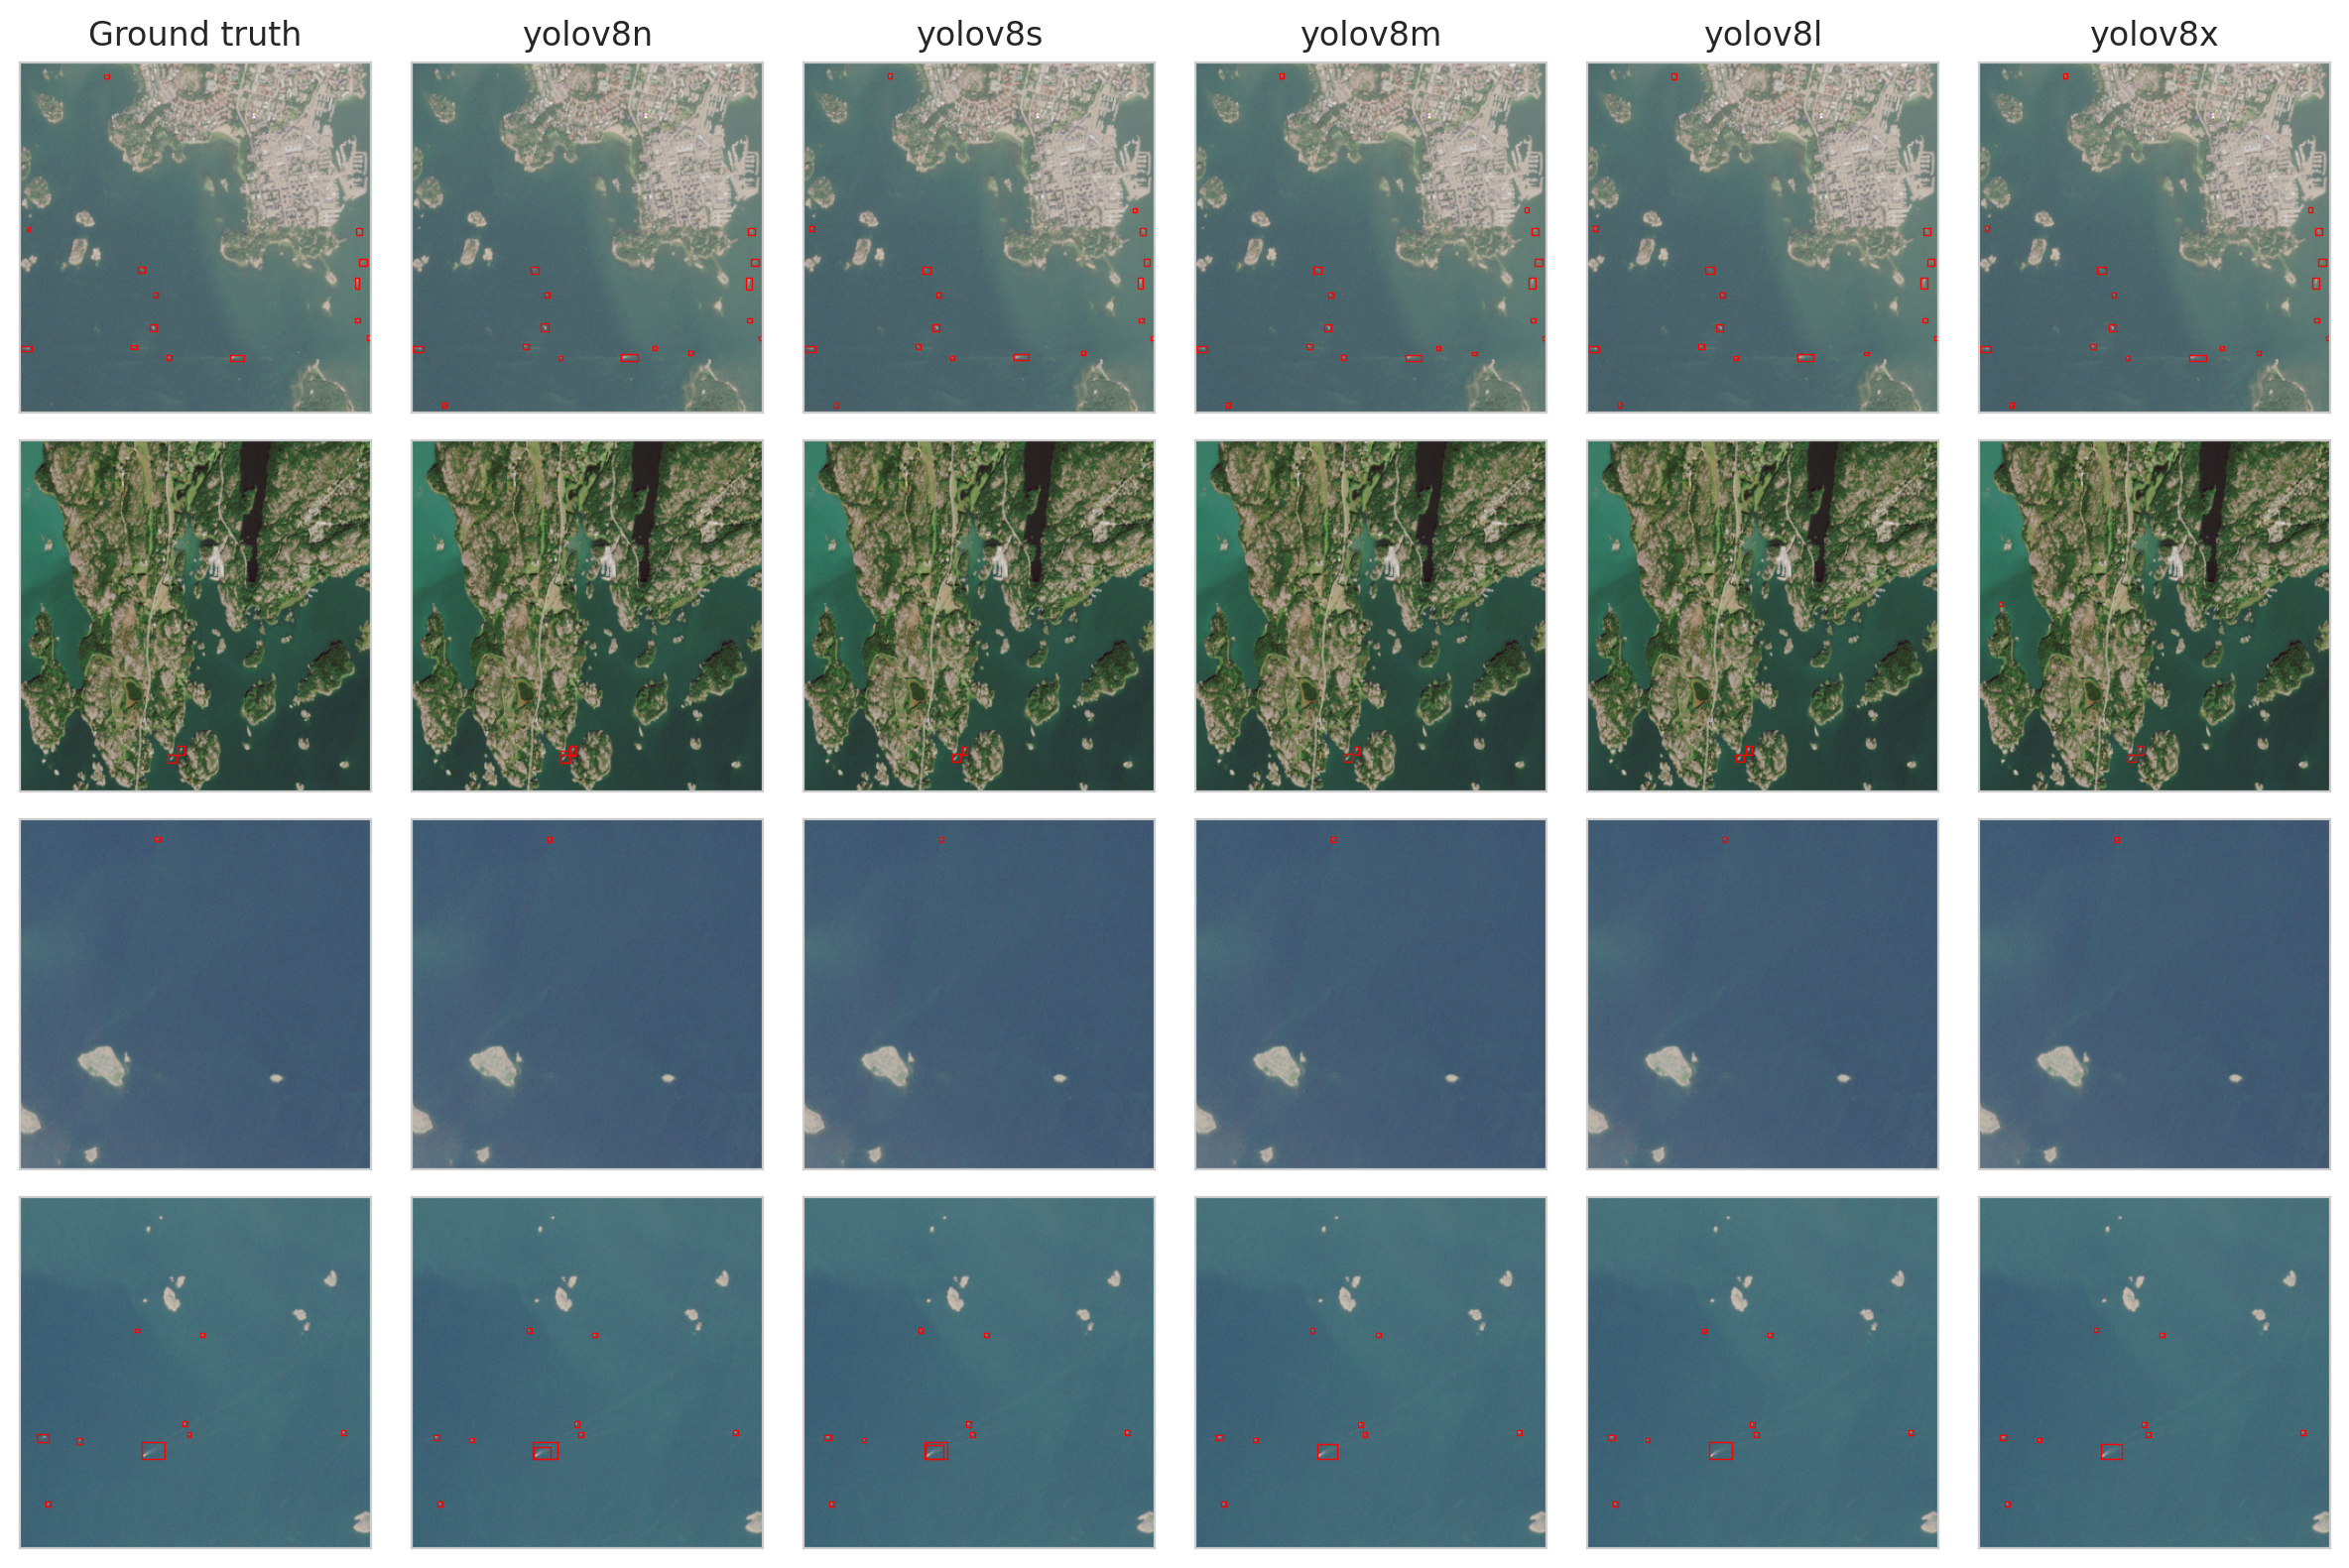

In [ ]:
#| echo: false
#| label: fig-exres
#| fig-cap: Example result comparison for different models

import random
from PIL import Image
from matplotlib.patches import Rectangle
from ultralytics import YOLO
import cv2


#with open('../data/processed/fold_3.txt') as src:
#    images = [i.replace('/scratch/project_2007454/ship_detection', '..') for i in src.read().split('\n')]
    
#testims = random.sample(images, 4)

testims = ['../data/processed/35VLG/20220721/images/R9C25.tif',
           '../data/processed/34VEM/20220813/images/R14C25.tif',
           '../data/processed/34VEM/20220721/images/R20C12.tif',
           '../data/processed/34VEM/20220721/images/R12C12.tif']

fig, axs = plt.subplots(4,6, dpi=200, figsize=(12,8))
for a in axs.flatten(): 
    a.set_xticks([])
    a.set_yticks([])

axs[0,0].set_title('Ground truth')
    
for i, t in enumerate(testims):
    im = Image.open(t)
    axs[i,0].imshow(im)
    with open(t.replace('images', 'labels').replace('tif', 'txt')) as src:
        anns = src.read().split('\n')[:-1]
    for ann in anns:
        xc, yc, w, h = [float(a)*320 for a in ann.split(' ')[1:]]
        axs[i,0].add_patch(Rectangle((xc-w/2, yc-h/2), w, h, edgecolor='red', facecolor='none', linewidth=.5))

for j, m in enumerate(models):
    axs[0,j+1].set_title(m.split('_')[0])
    model = YOLO(model_path/m/'fold_3/weights/best.pt')
    model.to('cuda')
    for i, t in enumerate(testims):
        im = Image.open(t)
        axs[i,j+1].imshow(im)
        preds = model(im, verbose=False)
        for xc, yc, w, h in preds[0].boxes.xywh.cpu():
            axs[i,j+1].add_patch(Rectangle((xc-w/2, yc-h/2), w, h, edgecolor='red', facecolor='none', linewidth=.5))
plt.tight_layout()
plt.savefig('../draft/fig-visual-res.png', dpi=200, bbox_inches='tight')

# Test set results

The predictions for the test set are cleaned using the following steps:

1. All prediction whose centroid points are not located on water are discarded. The water mask used contains layers `jarvi` (Lakes), `meri` (Sea) and `virtavesialue` (Rivers as polygon geometry) from the Topographic database by the National Land Survey of Finland. Unfortunately this also discards all points not within the Finnish borders. (The National Land Survey of Finland Topographic Database 04/2023, license CC 4.0 BY)
2. All predictions whose centroid points are located on water rock areas are discarded. The mask is the layer `vesikivikko` (Water rock areas) from the Topographic database.
3. All predictions that contain an above water rock within the bounding box are discarded. The mask contains classes `38511`, `38512`, `38513` from the layer `vesikivi` in the Topographical database.
4. All predictions that contain a lighthouse or a sector light within the bounding box are discarded. Lighthouses and sector lights come from Finnish Transport Infrastructure Agency, `ty_njr` class ids are 1, 2, 3, 4, 5, 8. (Finnish Transport Agency / Open API, license CC 4.0 BY)
5. All predictions that are wind turbines, found in Topographic database layer `tuulivoimalat`
6. TODO Filter aquaculture and net pens as soon as suitable layer for them is found
7. All predictions that are obviously too large are discarded. The prediction is defined to be "too large" if either of its edges is longer than 750 meters.

Topographic database can be acquired [here](https://www.maanmittauslaitos.fi/en/maps-and-spatial-data/expert-users/product-descriptions/topographic-database), and the data from Finnish Transport Infrastructure Agency is available [here](https://paikkatieto.vaylapilvi.fi/suomen-vaylat/?lang=en) (Maritime transport, Aids to navigation).

Evaluate the results with COCO metrics.

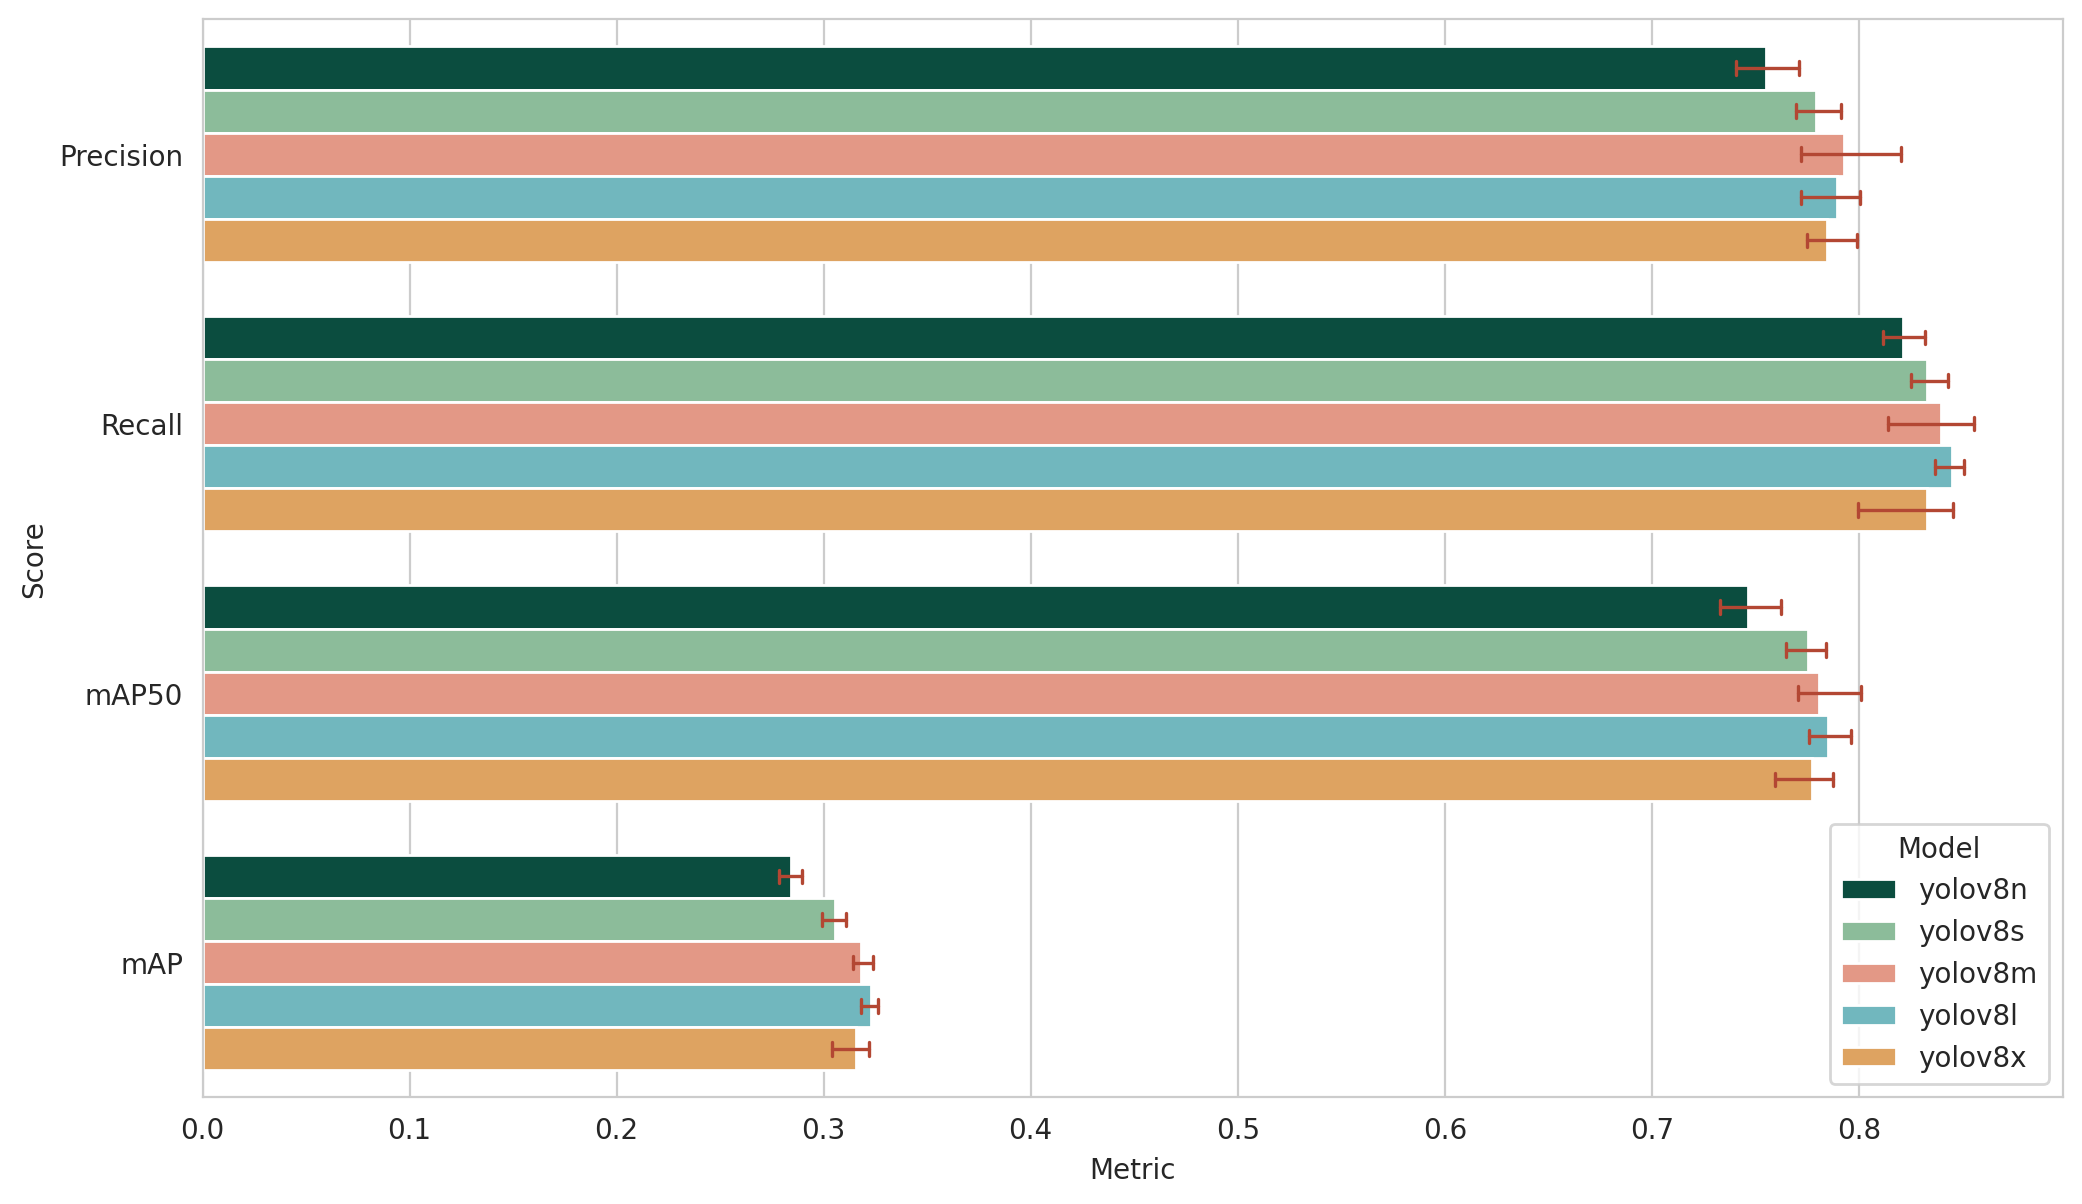

In [ ]:
#| echo: False
#| label: fig-testres
#| fig-cap: Test set results by model architecture.

def compute_precision_recall(pred_gdf:gpd.GeoDataFrame, gt_gdf:gpd.GeoDataFrame, 
                             iou_threshold:float, area_limit:gpd.GeoDataFrame=None) -> tuple[float, float]:
    """
    Compute precision and recall for polygon predictions and ground truth dataframes.

    Args:
        pred_gdf (geopandas.GeoDataFrame): Dataframe containing polygon predictions
        gt_gdf (geopandas.GeoDataFrame): Dataframe containing ground truth polygons
        iou_threshold (float): The intersection-over-union threshold to use for matching polygons.

    Returns:
        tuple: (precision, recall) as floats.
    """

    # Copy the dataframes to avoid modifying the originals
    pred_gdf_copy = pred_gdf.copy()
    gt_gdf_copy = gt_gdf.copy()
    
    if area_limit: # Clip to only contain some subarea
        pred_gdf_copy = pred_gdf_copy.clip(area_limit)
        gt_gdf_copy = gt_gdf_copy.clip(area_limit)
    
    # Count the number of true positives, false positives, and false negatives
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for index, pred_row in pred_gdf_copy.iterrows():
        # Find the ground truth polygons that overlap with the prediction
        overlapping_gts = gt_gdf_copy[gt_gdf_copy.geometry.intersects(pred_row.geometry)]
        if overlapping_gts.empty:
            false_positives += 1
        else:
            # Compute IoU between the prediction and overlapping ground truth polygons
            ious = overlapping_gts.geometry.intersection(pred_row.geometry).area / overlapping_gts.geometry.union(pred_row.geometry).area

            # Find the maximum IoU and corresponding index
            max_iou = np.max(ious.values)
            max_iou_index = np.argmax(ious.values)
            # If the maximum IoU is greater than the threshold, it's a true positive
            if max_iou >= iou_threshold:
                true_positives += 1

                # Remove the matched ground truth polygon to avoid double counting
                gt_gdf_copy.drop(overlapping_gts.index[max_iou_index], inplace=True)
            else:
                false_positives += 1

    # Any remaining ground truth polygons are false negatives
    false_negatives = len(gt_gdf_copy)
    # Compute precision and recall
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    return precision, recall

precs = []
recs = []
results = []
for m in models:
    mpre = []
    mrec = []
    for f in folds:
        fpre = []
        frec = []
        fap50 = []
        fmap = []
        tiles = os.listdir(f'../results_l1c/{m}/{f}')
        # Evaluate precision and recall
        for t in tiles:
            tsteps = [f for f in os.listdir(f'../data/annotated_ships/{t}') if f.endswith('shp')]
            for tstep in tsteps:
                targs = gpd.read_file(f'../data/annotated_ships/{t}/{tstep}')
                preds = gpd.read_file(f"../results_l1c/{m}/{f}/{t}/{tstep.replace('shp', 'geojson')}")
                pre, rec = compute_precision_recall(preds, targs, 0.5)
                fpre.append(pre)
                frec.append(rec)
                
        # Get mAP50 and mAP
        with open(f'../runs/{m}/{f}/eval.txt') as r:
            lines = [l.strip() for l in r.readlines()]
        lines = [l for l in lines if 'Average' in l]
        mAP50 = float(lines[1].split('=')[-1].strip())
        mAP = float(lines[0].split('=')[-1].strip())
        results.append([m.split('_')[0],f,np.mean(fpre),np.mean(frec), mAP50, mAP])
        mpre.append(np.mean(fpre))
        mrec.append(np.mean(frec))
    precs.append(mpre)
    recs.append(mrec)
resdf = pd.DataFrame(columns=['Model', 'fold', 'Precision', 'Recall', 'mAP50', 'mAP'], data=results)
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1, figsize=(12,7), dpi=200)
ax.set_ylim([0,1])
sns.barplot(y='variable', x='value', hue='Model', data=pd.melt(resdf, id_vars=['Model', 'fold']),
            palette=colors5, errorbar=('ci', 100), capsize=.05, errcolor='#b34733', errwidth=1.2)
sns.move_legend(ax, 'lower right')
plt.xlabel('Metric')
plt.ylabel('Score')

plt.show()

In [ ]:
resdf.pivot_table(values=['Precision', 'Recall', 'mAP50', 'mAP'], index=['Model'], 
                  aggfunc={'Precision':[min, max, np.mean],
                           'Recall':[min, max, np.mean],
                           'mAP50':[min, max, np.mean],
                           'mAP':[min, max, np.mean]})

Precision                        Recall                        mAP  \
              max      mean       min       max      mean       min    max   
Model                                                                        
yolov8l  0.801311  0.789472  0.772199  0.851569  0.844953  0.835289  0.326   
yolov8m  0.825823  0.792868  0.772218  0.857435  0.839866  0.807621  0.324   
yolov8n  0.773252  0.755268  0.738894  0.833611  0.821598  0.811092  0.290   
yolov8s  0.792886  0.779485  0.768628  0.845133  0.832765  0.825042  0.311   
yolov8x  0.801969  0.784667  0.773465  0.845454  0.832825  0.799519  0.322   

                        mAP50                 
           mean    min    max    mean    min  
Model                                         
yolov8l  0.3230  0.317  0.797  0.7854  0.776  
yolov8m  0.3180  0.314  0.801  0.7808  0.769  
yolov8n  0.2844  0.277  0.766  0.7466  0.732  
yolov8s  0.3054  0.298  0.784  0.7756  0.764  
yolov8x  0.3154  0.304  0.788  0.7776  0.755

Best performing model for each architecture is available on [https://huggingface.co/mayrajeo/marine-vessel-detection](https://huggingface.co/mayrajeo/marine-vessel-detection).